In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [15]:
save_results = True
experiment = 'lambda_3'
# experiment = 'ER'

In [16]:
with open(f'results/{experiment}/results_{experiment}.json', 'r') as json_file:
    results = json.load(json_file)
    N = results['N']
    nruns = results['nruns']
    crange = np.linspace(*results['crange'])
    results = results['results']

In [17]:
crange.shape

(200,)

In [18]:
N

100000

In [19]:
T = []
for result in results:
    T.append(np.mean([
        max(item['t'] for item in run['cascade'])
        for run in result['runs']
    ]))

max_t = max(item['t']
            for result in results
            for run in result['runs']
            for item in run['cascade'])

In [20]:
max_t

155

In [21]:
# for result in results:
#     for i, run in enumerate(result['runs']):
#         tvals = [item['t'] for item in run['cascade']]
#         for t in range(max(tvals), max_t + 1):
#             if result['c'] > 5:
#                 run['cascade'].append({
#                     't': t,
#                     'n_ap': 0,
#                     'gcc_size': N,
#                 })

In [22]:
n_ap = {t: [] for t in range(max_t + 1)}
gcc_size = {t: [] for t in range(max_t + 1)}

for result in results:

    n_ap_loc = {t: 0 for t in range(max_t + 1)}
    gcc_size_loc = {t: 0 for t in range(max_t + 1)}
    num_gcc_t = {t: 0 for t in range(max_t + 1)}

    for run in result['runs']:
        for item in run['cascade']:

            n_ap_loc[item['t']] += item['n_ap']
            gcc_size_loc[item['t']] += item['gcc_size']
            num_gcc_t[item['t']] += 1

    for t in range(max_t + 1):

        n_ap[t].append(n_ap_loc[t] / nruns / N)
        gcc_size[t].append(gcc_size_loc[t] / num_gcc_t[t] / N
                           if num_gcc_t[t]
                           else gcc_size[t - 1][-1])

In [23]:
gcc_inf = []
for i, t in enumerate(np.rint(T)):
    gcc_inf.append(gcc_size[t][i])

In [24]:
lw, ms = 1, 3
max_t_for_plots = min(10, max_t)
xmax = 12 if experiment == 'lambda_3' else 8
experiment

'lambda_3'

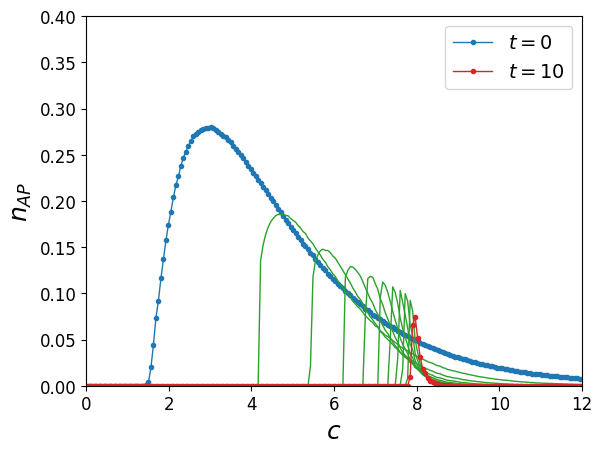

In [25]:
plt.plot(crange, n_ap[0], 'o-', lw=lw, ms=ms, color='tab:blue', label='$t = 0$')
for t in range(1, max_t_for_plots):
    plt.plot(crange, n_ap[t], '-', lw=lw, ms=ms, color='tab:green')
plt.plot(crange, n_ap[max_t_for_plots], 'o-', lw=lw, ms=ms, color='tab:red', label=f'$t = {max_t_for_plots}$')
plt.xlim(0, xmax)
plt.ylim(0, .4)
plt.xlabel('$c$', fontdict={'size': 18})
plt.ylabel('$n_{AP}$', fontdict={'size': 18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=14)
if save_results:
    plt.savefig(f'results/{experiment}/AP.png')
    plt.savefig(f'results/{experiment}/AP.pdf')

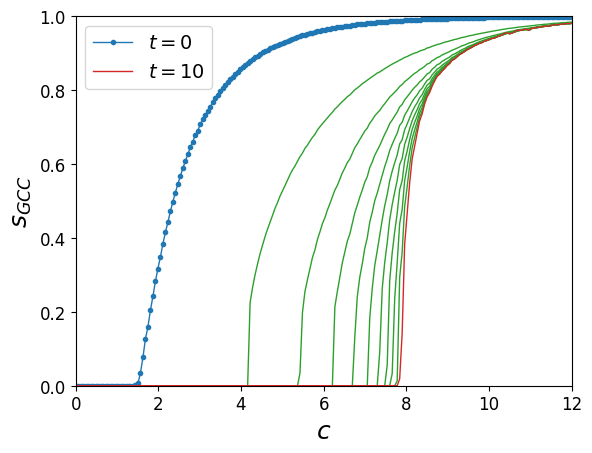

In [26]:
plt.plot(crange, gcc_size[0], 'o-', lw=lw, ms=ms, color='tab:blue', label='$t = 0$')
# for t in range(1, max_t_for_plots + 1):
for t in range(1, max_t_for_plots):
    plt.plot(crange, gcc_size[t], '-', lw=lw, ms=ms, color='tab:green')
# plt.plot(crange, gcc_inf, 'o-', lw=lw, ms=ms, color='tab:red', label='$t = \infty$')
plt.plot(crange, gcc_size[max_t_for_plots], '-', lw=lw, ms=ms, color='tab:red', label=f'$t = {max_t_for_plots}$')
plt.xlim(0, xmax)
plt.ylim(0, 1)
plt.xlabel('$c$', fontdict={'size': 18})
plt.ylabel('$s_{GCC}$', fontdict={'size': 18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=14)
if save_results:
    plt.savefig(f'results/{experiment}/GCC_size.png')
    plt.savefig(f'results/{experiment}/GCC_size.pdf')

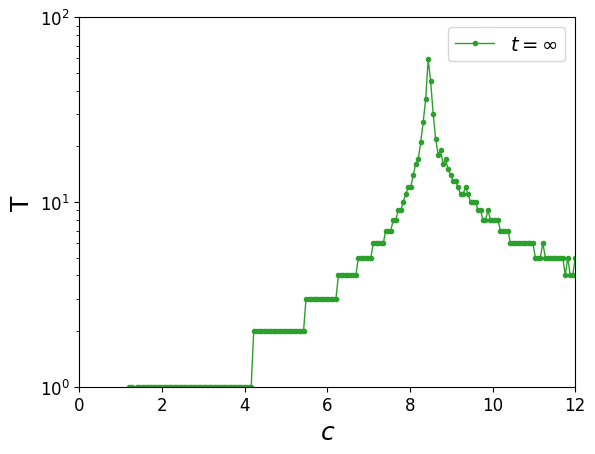

In [27]:
plt.semilogy(crange, np.rint(T), 'o-', ms=ms, lw=lw, color='tab:green', label='$t = \infty$')
plt.xlim(0, xmax)
plt.ylim(1, 100)
plt.xlabel('$c$', fontdict={'size': 18})
plt.ylabel('T', fontdict={'size': 18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=14)
if save_results:
    plt.savefig(f'results/{experiment}/t.png')
    plt.savefig(f'results/{experiment}/t.pdf')